# Searching for the category

In [1]:
import pandas as pd
import re

In [2]:
products_qc_df = pd.read_csv('3_Data_Cleaning/data/products_qc_df.csv')
df = products_qc_df.copy()
df = df.astype({'type': 'str'})
df.loc[df['sku'].isin(['SAN0017','SAN0026','SAN0035','PAC0602','ELG0014','PAC2056','GTE0093-A','DOD0010','SYN0173-A']),'type'] = '1111-A'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9992 entries, 0 to 9991
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sku     9992 non-null   object 
 1   brand   9992 non-null   object 
 2   name    9992 non-null   object 
 3   desc    9992 non-null   object 
 4   type    9992 non-null   object 
 5   price   9992 non-null   float64
dtypes: float64(1), object(5)
memory usage: 468.5+ KB


In [3]:
# ------------------------------------------------------------------
# 1️  map known type-codes to (category, subcategory)
# ------------------------------------------------------------------
TYPE_MAP = {
    # ---------- Mac Computers ----------
    '118692158': ("Computers", "iMac Pro"),
    '57400000': ("Computers", "iMac"),
    '21600000': ("Computers", "iMac"),
    '21632158': ("Computers", "Mac Pro"),
    '2158': ("Computers", "MacBook Pro"),
    '92900000': ("Computers", "MacBook Pro"),
    '10200000': ("Computers", "MacBook Pro"), # Mix of new and refurbished
    '51912158': ("Computers", "MacBook Pro Refurbished"),
    '1282': ("Computers", "MacBook Pro"), # Mix of different models
    '21700000': ("Computers", "MacBook"),
    '53900000': ("Computers", "MacBook"),
    '51902158': ("Computers", "MacBook Air Refurbished"),
    '54300000': ("Computers", "iMac Refurbished"),
    '57200000': ("Computers", "iMac Refurbished"),
    '51882158': ("Computers", "iMac Refurbished"),
    '21622158': ("Computers", "Mac Mini"),
    '54400000': ("Computers", "Mac Mini"),
    '54500000': ("Computers", "Mac Mini"),
    
    # ---------- iPhone ----------    
    '113271716': ("iPhone", "iPhone X"),
    '1111': ("iPhone", "iPhone 6"),
    '113281716': ("iPhone", "iPhone 8"),
    '51601716': ("iPhone", "iPhone SE"),
    '85641716': ("iPhone", "iPhone 7"),
    '85651716': ("iPhone", "iPhone 7"),
    '113291716': ("iPhone", "iPhone 8"),
    '21561716': ("iPhone", "iPhone 6 Refurbished"),
    '21571716': ("iPhone", "iPhone 6 Refurbished"),
    '24811716': ("iPhone", "iPhone 6s Refurbished"),
    '24821716': ("iPhone", "iPhone 6s Refurbished"),
    '1716': ("iPhone", "iPhone 6s"),
    
    # ---------- Portable Devices ----------
    '51861714': ("Portable Devices", "iPad Pro"),
    '51871714': ("Portable Devices", "iPad Pro"),
    '106431714': ("Portable Devices", "iPad Pro"),
    '12141714':("Portable Devices", "iPad Pro"),
    '1714': ("Portable Devices", "iPad Pro"),
    '113851714': ("Portable Devices", "iPad Refurbished"),
    '12051714': ("Portable Devices", "iPad Refurbished"),
    '12031714': ("Portable Devices", "iPad Mini 2"),
    '13621714': ("Portable Devices", "iPad Mini 4"),
    '24861714': ("Portable Devices", "iPad Mini 4"),
    '42931714': ("Portable Devices", "iPad Air 2 Refurbished"),
    '24885185': ("Portable Devices", "Apple Watch"),
    '24895185': ("Portable Devices", "Apple Watch"),
    '5185': ("Portable Devices", "Apple Watch"),
    '79201715': ("Portable Devices", "iPod Touch"),
    '11821715': ("Portable Devices", "iPod Touch"),
    '113464259': ("Portable Devices", "Apple TV Refurbished"),
    '4259': ("Portable Devices", "Apple TV Refurbished"),
    '1405': ("Portable Devices", "Graphics Tablet"),

    # ---------- Watch Accessories ----------
    '5405': ("Watch Accessories", "Armband & Bracelet for iPhone & Apple Watch"),
    '24215399': ("Watch Accessories", "Charging Dock for Apple Watch"),
    '2449': ("Watch Accessories", "Strap for Apple Watch"),
    '2434': ("Watch Accessories", "Screen Protector for Apple Watch"),
    '2425': ("Watch Accessories", "Screen Protector for Apple Watch"),
    '12282': ("Watch Accessories", "Stand for Apple Watch"),

    # ---------- Cases & Protection ----------
    '11865403': ("Cases & Protection", "Case"),
    '5403': ("Cases & Protection", "Case"),
    '12635403': ("Cases & Protection", "Tablet Case"),
    '14035403': ("Cases & Protection", "Screen Protector"),
    '13555403': ("Cases & Protection", "Screen Protector"),
    '13835403': ("Cases & Protection", "Sleeve"),
    '1392': ("Cases & Protection", "Bag"),
    '10230': ("Cases & Protection", "Bag"),

    # ---------- Power & Charging ----------
    '1515': ("Power & Charging", "Battery"),
    '10142': ("Power & Charging", "Battery"),
    '5407': ("Power & Charging", "Battery"),
    '54900000': ("Power & Charging", "Battery Case"),
    '13005399': ("Power & Charging", "Charger"),
    '13615399': ("Power & Charging", "Charger"),
    '5399': ("Power & Charging", "Charger"),
    
    # ---------- Stand &  Mount ----------
    '5720': ("Stand & Mount", "Stand"),
    '1216': ("Stand & Mount", "Stand"),
    '8696': ("Stand & Mount", "Support"),

    # ---------- Storage ----------
    '42945397': ("Storage", "Flash Drive"),
    '57445397': ("Storage", "Flash Drive"),
    '12215397': ("Storage", "SSD Expansion"),
    '12995397': ("Storage", "External Storage"),
    '11935397': ("Storage", "External Storage"),
    '12655397': ("Storage", "Hard Drive"),
    '1433': ("Storage", "SSD"),
    '1424': ("Storage", "External DVD Recorder"),
    '1364': ("Storage", "Mac RAM Memory DDR"),

    # ---------- Networking ----------
    '12175397': ("Networking", "NAS System"),
    '1404': ("Networking", "NAS System"),
    '1280': ("Networking", "NAS System"),
    '1334': ("Networking", "Router & Switch"),
    
    # ---------- Audio & Video ----------
    '5384': ("Audio & Video", "Headphones"),
    '5404': ("Audio & Video", "Camera"),
    '9094': ("Audio & Video", "Surveillance Camera"),
    '54864259': ("Audio & Video", "Remote Control"),
    '1375': ("Audio & Video", "Microphone"),
    '5398': ("Audio & Video", "Speaker"),
    '1296': ("Audio & Video", "Monitor"),
    '1416': ("Audio & Video", "Video & Photo Edition Software"),

    # ---------- Cables & Adapters ----------
    '1230': ("Cables & Adapters", "Lightning USB Cable"),
    '1325': ("Cables & Adapters", "Thunderbolt Video Cable"),
    '12585395': ("Cables & Adapters", "Video Adapter"),
    '1276': ("Cables & Adapters", "PCI SSD Adapter"),
    '5395': ("Cables & Adapters", "Generic Adapter"),
    '14365395': ("Cables & Adapters", "Generic Adapter"),
    '13955395': ("Cables & Adapters", "Generic Adapter"),
    '54085407': ("Cables & Adapters", "Generic Adapter"),
    '11434': ("Cables & Adapters", "Generic Adapter"),
    
    # ---------- Peripherals ---------- 
    '1229': ("Peripherals", "Digital Pen"),
    '13855401': ("Peripherals", "Keyboard"),
    '5401': ("Peripherals", "Keyboard"),
    '54025401': ("Peripherals", "Keyboard"),
    '12575403': ("Peripherals", "Keyboard"),
    '1387': ("Peripherals", "Mouse & Trackpad"),

    # ---------- Smart Home & IoT ----------
    '11905404': ("Smart Home & IoT", "Smart-Gadgets"),
    '11859': ("Smart Home & IoT", "Smart Home Sensors"),
    '15435404': ("Smart Home & IoT", "Motion Controller"),
    
    # ---------- Tools & Repair ----------    
    '12645406': ("Tools & Repair", "Replacement Part"),
    '12755395': ("Tools & Repair", "Replacement Part"),
    '21485407': ("Tools & Repair", "Replacement Part"),
    '21535407': ("Tools & Repair", "Replacement Part"),
    '101781405': ("Tools & Repair", "Replacement Part"),
    '14305406': ("Tools & Repair", "Toolkit"),
    '12285400': ("Tools & Repair", "Toolkit"),
    #'12355400': ("Tools & Repair", "Cleaning & Maintenance"),
    '5406': ("Tools & Repair", "Toolkit"),
    '12085400': ("Tools & Repair", "Cleaning & Maintenance"),
    '20642062': ("Tools & Repair", "Installation Service"),
    '1231': ("Tools & Repair", "Warranty"),
    '14400000': ("Tools & Repair", "Repair Service"),
    
    # ---------- Open-Box ----------   
    #'1298': ("Open-Box", "Open-Box Items"),

}

In [4]:
# ------------------------------------------------------------------
# 2️  rules for categorizing products based on their name or description
# ------------------------------------------------------------------
 
# ────────────────────────────────────────────────────────────────
# 1⃣  shared prefix:  start-of-line  +  optional condition  +  Apple
# ────────────────────────────────────────────────────────────────
PREFIX = (
    r"^\s*"                                  # any leading spaces
    r"(?:"                                   # optional “condition -”
        r"(?:\((?:open)\)|open|like\s*new|"   #  (Open) | Open | Like new
        r"second\s*hand|excellent|well|"      #  Second hand | Excellent | Well
        r"abierto|very\s*good)"               #  Abierto | Very Good
        r"\s*-\s*"                            #  dash splitter
    r")?"                                     # whole condition block optional
    r"apple\b\s+"                             # …and finally the word “Apple”
)

 
    # ----------  REGEX_RULES  ----------
REGEX_RULES = [

    # ────────────────────────────────────────────────────────────────
    # 2⃣  rebuilt COMPUTER rules (case-insensitive)
    # ────────────────────────────────────────────────────────────────

    ("Computers", "MacBook Pro", fr"{PREFIX}macbook\s+pro\b"),

    ("Computers", "MacBook Air", fr"{PREFIX}macbook\s+air\b"),

    ("Computers", "MacBook", fr"{PREFIX}macbook\b"),

    ("Computers", "iMac Pro", fr"{PREFIX}imac\s+pro\b"),

    ("Computers", "iMac", fr"{PREFIX}imac\b"),

    ("Computers", "Mac Pro", fr"{PREFIX}mac\s*pro\b"),

    ("Computers", "Mac Mini", fr"{PREFIX}mac\s*mini\b"),



    # ─ Networking  ----------
    ("Networking", "NAS System",
     r"\b(synology|qnap|drobo)\s*(ds|ts|rx)?\d{3,5}\b"),
    ("Networking", "NAS Expansion Unit / Chassis",
     r"\b(expansion|dx|rx)[-_]?\d{3,4}\b"),

    # ─ Audio & Video  ----------
    ("Audio & Video", "Camera Lens Attachment",
     r"\bolloclip\b.*\blens\b"),
    ("Audio & Video", "Headphones",
     r"\bbluetooth\b.{0,40}\b(head(set|phones?)|earbuds?|hands\s*free)\b"),

    # ─ Smart Home & IoT  ----------
    ("Smart Home & IoT", "Smart Lighting",
     r"\bwemo\b.*\b(bulb|led|light)\b"),
    ("Smart Home & IoT", "Smart Wearables & Health",
     r"\bsmart\s*watch\b|\bbluetooth\b.{0,30}\bwatch\b"),

    # ─ Cables & Adapters  ----------
    ("Cables & Adapters", "Audio Cable",
     r"\b(3\.5\s*mm|jack)\b.{0,20}\b(jack|cable|aux)\b"),
    ("Cables & Adapters", "Generic Adapter",   # MagSafe ↔︎ MagSafe 2
     r"\bmagsafe\b.{0,20}\bconverter\b"),
    ("Cables & Adapters", "Video Adapter",     # Mini-DP → HDMI 4 K
     r"\bmini\s*display\s*port\b.{0,40}\bhdmi\b|\bmdp\b.{0,40}\bhdmi\b"),

    # ─ Stand & Mount  ----------
    ("Stand & Mount", "Stand",
     r"\bselfie\b.{0,40}\b(stick|monopod|trigger)\b"),

    # ─ Power & Charging  ----------
    ("Power & Charging", "Charger",
     r"\bmagnetic\s*charging\s*cable\b.*apple\s*watch"),

    # ─ Tools & Repair  ----------
    ("Tools & Repair", "General Repair Toolkit",
     r"\bmacro\s*bit\s*kit\b"),
    ("Tools & Repair", "Battery Replacement Kit",
     r"\bcomplete\s+repair\s*(?:kit)?\b.*\biphone\b"),
    ("Tools & Repair", "Replacement Part",
     r"\b(lightning|audio)\s*connector\b.*iphone"),
    ("Tools & Repair", "Opening / Pry Tools",
     r"\bsuction\s*cups?\b|battery\s*isolation\s*pick"),

    # ---------- Tools & Repairs -----------------------------------------------

    ("Tools & Repair","General Repair Toolkit",
        r"\b(complete\s+set\s+of\s+\d+\s+tools|tools?\s*set|tool\s*kit)\b"),
    
    # ─ Tools & Repair : Opening / Pry tools ----------
    ("Tools & Repair", "Opening / Pry Tools",
        r"(suction\s*cup|isolation\s*pick|spudger|jimmy)"),
    
    # ─ Tools & Repair : Adhesive / Seal ----------
    ("Tools & Repair", "Adhesive / Seal & Gasket",
        r"adhesive\s*strip|tape"),
    
    # ─ Tools & Repair : Drive Installation Kits ----------
    ("Tools & Repair", "Drive Installation Kit",
        r"(ssd|hdd|drive).{0,20}installation\s*kit"),
    
    # ─ Tools & Repair : Battery kits ----------
    ("Tools & Repair", "Battery Replacement Kit",
        r"\bbattery\s*(kit|change|replacement)\b"),

    # ─ Tools & Repair : Screen / display kits ----------
    ("Tools & Repair", "Screen / Display Replacement Kit",
        r"\b(display|screen)\s*(kit|change|replacement)\b"),

    # ─ Tools & Repair : General toolkits (multi-bit, iOpener, etc.) ----------
    ("Tools & Repair", "General Repair Toolkit",
        r"\b(toolkit|tool\s*kit|97\s*bit|bit\s*driver|essential\s*tool|pro\s*tech|"
        r"tool\s*set|iopener|electronics\s*tool)\b"),

    # ─ Tools & Repair : Specialty screwdrivers / bit only ----------
    ("Tools & Repair", "Specialty Screwdriver / Bit",
        r"\b(screwdriver|pentalobe|torx|tri[-\s]?wing|security\s*bit|bit\s*set)\b"),

    # ─ Tools & Repair : Opening / Pry tools ----------
    ("Tools & Repair", "Opening / Pry Tools",
        r"\b(opening\s*tool|jimmy|pry|spudger|plastic\s*card)\b"),

    # ─ Tools & Repair : SIM tools ----------
    ("Tools & Repair", "SIM / Eject Tools",
        r"\bsim\s*card\s*eject\b|\bsim\s*eject\b"),

    # ─ Tools & Repair : Magnetic work mats ----------
    ("Tools & Repair", "Magnetic Work Mat",
        r"\bmagnetic\s*(mat|project\s*mat)\b"),

    # ─ Tools & Repair : Moisture absorber ----------
    ("Tools & Repair", "Moisture Absorber Bag",
        r"\b(thirsty\s*bag|moisture\s*absorber|dry\s*bag)\b"),

    # ─ Tools & Repair : Repair Support / holders ----------
    ("Tools & Repair", "Repair Support / Holder",
        r"\brepair\s*support|device\s*holder|magnetic\s*pad\b"),
    
    # ─ Tools & Repair : Replacement Part ----------
    ("Tools & Repair", "Replacement Part",
        r"(replacement|replace).{0,10}(tip|tips|nib|nibs|disc|pointer)s?\b|"
        r"\b(tip|tips|nib|nibs|disc|pointer).{0,10}(replacement|replace)\b|"
        r"\bmagsafe\b.{0,30}\b(dc[-\s]?in|connector|board)\b"),
    
        # --- Tools & Repair ---
    ("Tools & Repair", "Cleaning & Maintenance", r"\bclean(er|ing)\b"),
    ("Tools & Repair", "Replacement Part",       r"\breplacement\s+part\b"),
    ("Tools & Repair", "Toolkit",                r"\btool.?kit\b"),
    ("Tools & Repair", "Warranty",               r"\bwarranty\b"),
    ("Tools & Repair", "Service",                r"\bservice\b"),

    # ---------- Smart Home & IoT -----------------------------------------------
    
        # ─ Smart Home & IoT : Smart Security & Alarms ----------
    ("Smart Home & IoT", "Smart Security & Alarms",
        r"\b(alarm|siren|security\s*system|motion\s*(?:detector|sensor)|door(?:s| & windows)?\s*sensor|"
        r"smoke\s*detector|carbon\s*monoxide|pir\s+sensor|panic\s*button)\b"),

    # ─ Smart Home & IoT : Smart Plugs & Power ----------
    ("Smart Home & IoT", "Smart Plugs & Power",
        r"\b(smart\s*(?:plug|socket|outlet)|eve\s*energy|hs1[01]0|wemo\b.*switch|"
        r"power\s*(?:socket|monitor)|wi[-\s]?fi\s*plug)\b"),

    # ─ Smart Home & IoT : Smart Locks & Entry ----------
    ("Smart Home & IoT", "Smart Locks & Entry",
        r"\b(lock|padlock|deadbolt)\b.*\b(bluetooth|smart|app)\b|\bnoke\b"),

    # ─ Smart Home & IoT : Bluetooth Trackers / Finders ----------
    ("Smart Home & IoT", "Bluetooth Trackers / Finders",
        r"\b(tile|trackr|gablys|chipolo)\b|\bbluetooth\b.{0,40}\b(locator|tracker)\b"),

    # ─ Smart Home & IoT : Smart Wearables & Health ----------
    ("Smart Home & IoT", "Smart Wearables & Health",
        r"\b(fitbit|withings|jawbone|wahoo|heart\s*rate|cadence|smart\s*scale|activity\s*monitor|"
        r"pulse\s*oximeter|blood\s*pressure)\b"),

    # ─ Smart Home & IoT : Drones & Robots ----------
    ("Smart Home & IoT", "Drones & Robots",
        r"\b(parrot\b.*drone|mini\s*drone|jumping\s*drone|hydrofoil|sphero|ubtech|robot(ic)?|"
        r"stormtrooper|droid|alpha\b.*robot)\b"),

    # ─ Smart Home & IoT : VR / AR Devices ----------
    ("Smart Home & IoT", "VR / AR Devices",
        r"\b(vr\s*(?:headset|glasses)|virtual\s*reality|augmented\s*reality|homido|cardboard\s*viewer)\b"),

    # ─ Smart Home & IoT : STEM / Maker Kits ----------
    ("Smart Home & IoT", "STEM / Maker Kits",
        r"\b(littlebits|osmo|runware|diy\s*kit|robot\s*kit|coding\s*kit|educational\s*kit|"
        r"inventor|gizmos\s*and\s*gadgets)\b"),

    # ─ Smart Home & IoT : Smart Garden & Plant Care ----------
    ("Smart Home & IoT", "Smart Garden & Plant Care",
        r"\b(flower\s*power|garden\s*sensor|plant\s*sensor|koubachi|soil\s*sensor|"
        r"sunlight\s*garden)\b"),

    # ─ Smart Home & IoT : Smart Thermostats & Climate ----------
    ("Smart Home & IoT", "Smart Thermostats & Climate",
        r"\b(thermostat|nest\s*protect|netatmo\b.*weather|climate\s*control|temperature\s*sensor)\b"),    
    
    # ---------- Smart Home & IoT : Smart Lighting ----------
    ("Smart Home & IoT", "Smart Lighting",
        r"\bhue\b|\blight\s*strip\b|\bbloom\b|\bbulb\b"),

    # ---------- Smart Home & IoT : Smart-Gadgets  (extend) ----------
    ("Smart Home & IoT", "Smart-Gadgets",
        r"\b(sphero|robot)\b|\bihealth\b|\bglucom(et(er|ro)|glucose)\b"),               
    
    # --- Smart Home & IoT ----------
    ("Smart Home & IoT", "Motion Controller",    r"\bmotion\s+controller\b"),
    ("Smart Home & IoT", "Smart Home Sensors",   r"\bsensor\b|fibaro"),
    
    # ---------- Power & Charging -----------------------------------------------   

    # ─── Power & Charging : Charger / Battery ----------
    ("Power & Charging", "Charger",
    r"\b(charger|charging\s*dock|power\s*bank|power\s*bar).{0,40}\b(?:for|para|compatible\s*with)\b"),
    ("Power & Charging", "Battery",
    r"\b(extra|replacement|external)\s*battery\b.{0,40}\b(?:for|para|compatible\s*with)\b"),
    
    # ─ Power & Charging ----------
    ("Power & Charging", "Charger",
        r"\b(charger|charging\s*(?:kit|dock|cradle)|magic\s*charger|power\s*bar)\b"),
    ("Power & Charging", "Battery",
        r"\b(extra|additional)\s*battery\b|bacpac\b"),
    
    # --- Power & Charging ----------
    ("Power & Charging", "Battery",  r"\bbattery\b|nupower"),
    ("Power & Charging", "Charger",  r"\bcharger\b|\bpower\s+adapter\b|\bpower\s+supply\b"), 

    # ---------- Stand & Mount ----------------------------------------------- 

    # ─── Stand & Mount : Stand / Support / Dock ----------
    ("Stand & Mount", "Stand",
        r"\b(stand|support|dock|holder|mount).{0,40}\b(?:for|para|compatible\s*with)\b.*\b(ip(?:hone|ad)|mac(?:book|mini)|imac|watch)\b"),

    # ─ Stand & Mount ----------
    ("Stand & Mount", "Headphone Stand",
        r"\b(head|phone|headphone)\s*stand\b|headstand"),
    ("Stand & Mount", "Laptop Stand",
        r"\b(laptop|macbook|notebook)\s*(stand|kickflip)\b"),
    ("Stand & Mount", "Device Mount",
        r"\b(mount|bracket|vesa)\b.*\b(airport|apple\s*tv|express)\b"),
    
    # --- Stand & Mount ----------
    ("Stand & Mount", "Support",     r"\bsupport\b"),
    ("Stand & Mount", "Mount",     r"\bmount\b"),
    ("Stand & Mount", "Stand",       r"\bstand\b"),
    
    
    # ---------- Storage -----------------------------------------------

    ("Storage", "Flash Drive",        
        r"\b(?:flash|usb|pen)\s+drive\b|\bixpand\b"
        r"|"
        r"\b(jump|pen)\s*drive\b"
        r"|"
        r"\bjetdrive\s+lite\b"),
    
    ("Storage", "Enclosure / Dock",
        r"\b(ministack|external\s+(?:box|enclosure|drive)|drive\s+enclosure|chassis)\b"
        r"|"
        r"\b(enclosure|chassis|(?:drive|hdd|ssd)\s*dock)\b"
        r"|"
        r"\b(dock)\b.{0,30}\b(sata|hdd|ssd|2\.5\"|3\.5\")\b"),
    
    ("Storage", "External DVD / Blu-ray",
        r"\b(blu[- ]?ray|dvd)\b.{0,40}\b(writer|recorder|drive)\b"
        r"|"
        r"\bsuper\s*drive\b|\busb\s*super\s*drive\b"),

    # ("Storage", "RAM Memory",         r"\bram\b|\bmemory\b|\ddr\b"),

    ("Storage", "RAM Memory",
        r"(?=.*\b(ddr\d|so[-\s]?dimm|ram\s*(?:module|kit)|memory\s*upgrade)\b)"),
    
    ("Storage", "SSD",      r"\bssd\b|solid\s+state"),
    
    ("Storage", "Hard Drive",         
        r"\b(?:hard\s*drive|disk|hdd|barracuda|western\s+digital|seagate)\b"),
    
    ("Storage", "External Storage",   r"\bexternal\b.*\bstorage\b|\brack\s*raid\b|\braid\b"),
    
    # ---------- Cables & Adapters -----------------------------------------------  
    
    ("Cables & Adapters", "Video Adapter",
         r"\bdigital\s*av\s*adapter\b"                     # literal phrase
         r"|"
         r"\blightning\b.{0,40}\b(hdmi|digital\s*av)\b"    # Lightning near HDMI
         r"|"
         r"\b(hdmi|digital\s*av)\b.{0,40}\blightning\b"
         r"|"
         r"dvi\s+to\s+mini\s*display\s*port|mini\s*display\s*port.*dvi"
         r"|"
         r"\b(hdmi|display\s*port|mini\s*display\s*port|vga|dvi).{0,40}\badapter\b.{0,40}\b(?:for|para|compatible\s*with)\b"
         r"|"
         r"\bmini\s*display\s*port\b.{0,40}\bhdmi\b|\bmdp\b.{0,40}\bhdmi\b"
         r"|"
         r"\b(hdmi|dvi|displayport|vga).{0,40}\badapter\b"),

    ("Cables & Adapters", "Generic Adapter",
         r"\busb[-\s]?c\b.{0,40}\badapter\b.{0,40}\busb[-\s]?a\b"
         r"|"
         r"\busb[-\s]?a\b.{0,40}\badapter\b.{0,40}\busb[-\s]?c\b"
         r"|"
         r"\badapter\b.{0,40}\b(?:for|para|compatible\s*with)\b"
         r"|"
         r"\bmagsafe\b.{0,20}\bconverter\b"
         r"|"
         r"\bthunderbolt\b.{0,40}\b(usb|ethernet)\b|\b(pcie?)\b.{0,40}\bethernet\b"
         r"|"
         r"\bthunderbolt\b.{0,40}\bfire\s*wire|firewire\b"
         r"|"
         r"\bfire\s*wire|firewire\b.{0,40}\bthunderbolt\b"),

    ("Cables & Adapters", "USB Extension",
        r"\bjimi\b.*\busb\b.{0,20}\b(expansion|extension)\b"),

    ("Cables & Adapters", "Video Adapter",
        r"dvi\s+to\s+mini\s*display\s*port|mini\s*display\s*port.*dvi"
        r"|"
        r"\b(hdmi|display\s*port|mini\s*display\s*port|vga|dvi).{0,40}\badapter\b.{0,40}\b(?:for|para|compatible\s*with)\b"
        r"|"
        r"\bmini\s*display\s*port\b.{0,40}\bhdmi\b|\bmdp\b.{0,40}\bhdmi\b"
        r"|"
        r"\b(hdmi|dvi|displayport|vga).{0,40}\badapter\b"),

    ("Cables & Adapters", "USB Hub",
        r"\busb[-\s]*(c|[23]\.\d)?.{0,25}hub\b.{0,40}\b(?:for|para|compatible\s*with)\b"
        r"|"
        r"\busb[-\s]*(c|[23]\.\d)?\b.{0,25}\bhub\b|\bhub\b.{0,25}\busb\b"
        r"|"
        r"\busb(?:\s*\d\.\d)?\s*hub\b|\bhub\b.{0,20}\busb\b"),
    
    ("Cables & Adapters", "Wi-Fi Adapter",
        r"\busb\s*wireless\s*adapter\b|wi[-\s]?fi\s*adapter"),

    ("Cables & Adapters", "Card Reader",
        r"\b(sd|cf|micro\s*sd|reader\/writer|card\s*reader)\b"),   
    
    ("Cables & Adapters", "Lightning USB Cable",
        r"\b(lightning|usb).{0,40}\bcable\b"),
    
    ("Cables & Adapters", "Thunderbolt Cable",
        r"\b(thunderbolt|usb4|usbc).{0,40}\bcable\b"),
    
    ("Cables & Adapters", "Video Cable",
        r"\b(hdmi|displayport|vga|dvi).{0,40}\bcable\b"),
    
    ("Cables & Adapters", "PCI SSD Adapter",
        r"\b(pci[- ]?e?).{0,20}\bssd\b.{0,20}\badapter\b"),

    # ---------- Cases & Protection ----------------------------------------------- 
    
    ("Cases & Protection", "Sleeve",           
        r"\bsleeve\b|"
        r"\bla\s*robe\b|\bmacbook\s+\d{2}\"\s*sheath\b"),
    
    ("Cases & Protection", "Bag",              
        r"\bbag\b|"
        r"\b(back\s*pack|backpack|suit\s*line)\b.*\bmacbook\b"),
    
    ("Cases & Protection", "Case",
        r"\b(case|cover|sleeve|bag).{0,40}\b(?:for|para|compatible\s*with)\b.*\b(ip(?:hone|ad)|mac(?:book|mini)|imac)\b|"
        r"\bcase\b|\bcover\b|\bhousing\b"),

    ("Cases & Protection", "Screen Protector",
        r"\b(screen\s*protector|protector).{0,40}\b(?:for|para|compatible\s*with)\b.*\b(ip(?:hone|ad))\b"),

    ("Cases & Protection", "Cable Management",
        r"cabledrop|cable\s*clip|cable\s*management"),

    ("Cases & Protection", "Security Lock",
        r"\b(lock|locking\s*(station|kit)|kensington|security\s*mount)\b"),
    
    ("Cases & Protection", "Desk Mat",
        r"\bdesk\s*mat\b|\bmat\b.{0,20}(aluminum|satechi)"),
    
    ("Cases & Protection", "Screen Protector", r"\bscreen\s*protector\b|\bprotector\b"),
    
    ("Cases & Protection", "Keyboard Protector", r"\bkeyboard\s*protector\b"),
    
    ("Cases & Protection", "Tablet Case",      r"\btablet\s+case\b"),

    # ---------- Apple Watch Accesories ----------------------------------------------- 
    
        # ── Armband & Bracelet (for iPhone / Apple Watch) ----------
    ("Watch Accessories", "Armband & Bracelet for iPhone & Apple Watch",
         r"\b(arm\s*band|armband|bracelet)\b.*\b(iphone|apple\s*watch|watch)\b"
         r"|\b(iphone|apple\s*watch|watch)\b.*\b(arm\s*band|armband|bracelet)\b"),

    # ── Charging Dock for Apple Watch  ----------
    ("Watch Accessories", "Charging Dock for Apple Watch",
         r"\bcharging\s*(dock|stand|base|station)\b.*\bapple\s*watch\b"
         r"|\bapple\s*watch\b.*\bcharging\s*(dock|stand|base|station)\b"),

    # ── Strap for Apple Watch  ----------
    ("Watch Accessories", "Strap for Apple Watch",
         r"\b(strap|loop|band)\b.*\bapple\s*watch\b"
         r"|\bapple\s*watch\b.*\b(strap|loop|band)\b"),

    # ── Screen Protector for Apple Watch  ----------
    ("Watch Accessories", "Screen Protector for Apple Watch",
         r"\b(screen\s*protector|protector|shield|glass|film)\b.*\bapple\s*watch\b"
         r"|\bapple\s*watch\b.*\b(screen\s*protector|protector|shield|glass|film)\b"),

    # ── Stand for Apple Watch (non-charging)  ----------
    ("Watch Accessories", "Stand for Apple Watch",
         r"\b(stand|support|holder|dock)\b(?![^]{0,30}\bcharging\b).*"
         r"\bapple\s*watch\b"
         r"|\bapple\s*watch\b.*\b(stand|support|holder|dock)\b(?![^]{0,30}\bcharging\b)"),
    
    # ---------- Audio & Video ----------------------------------------------- 

    # ─ Audio & Video (camera add-ons) ----------
    ("Audio & Video", "Camera Mount & Housing",
        r"\b(gopro|housing|harness|strap|handlebar|fetch|bacpac)\b"),
    
    # --- Audio & Video ---
    ("Audio & Video", "Surveillance Camera", r"\bsurveillance.*camera\b"),
    ("Audio & Video", "Camera",       r"\bcamera\b"),
    ("Audio & Video", "Monitor",      r"\bmonitor\b|\bdisplay\b"),
    ("Audio & Video", "Headphones",   r"\bheadphones?\b|earbuds?|earphones?"),
    ("Audio & Video", "Speaker",      r"\bspeaker?\b|speakers?"),
    ("Audio & Video", "Microphone",   r"\bmicrophone\b"),
    ("Audio & Video", "Remote Control",r"\bremote(?:\s+control)?\b"),

    # ---------- Peripherals -----------------------------------------------

    # ─── Peripherals : Keyboard / Mouse accessory ----------
    ("Peripherals", "Keyboard Accessory",
        r"\b(keyboard|numpad|numeric\s*pad).{0,40}\b(?:for|para|compatible\s*with)\b"),
    
    ("Peripherals", "Mouse & Trackpad",
        r"\b(mouse|trackpad).{0,40}\b(?:for|para|compatible\s*with)\b"),

    # ─ Peripherals : Calibration & Scanning ----------
    ("Peripherals", "Calibration Tool",
        r"\b(color\s*(munki|munki\s*display|display\s*pro)|colormunki|munki|"
        r"calibrator|colorimeter|i1\s*display|spectro)\b"),
    ("Peripherals", "Portable Scanner",
        r"\b(palette\s*color\s*cube|cube\s*portable\s*scanner)\b"),

    # ─ Peripherals : Keyboard accessory — numeric overlay ----------
    ("Peripherals", "Keyboard Accessory",
        r"\bmagic\s*numpad\b"),
    
    # ---------- Peripherals : Digital Pen ----------
    # ‘Jot Script’, ‘Jot Pro’, ‘Evernote Pointer’ …
    ("Peripherals", "Digital Pen",
        r"\b(adonit|jot)\b.{0,40}(script|pro|pointer|pen|stylus)|\bdigital\s+pen\b"),
    
    # ---------- Peripherals : Calibration Tool ----------
    ("Peripherals", "Calibration Tool",
        r"\b(color|colour)\s*(manager|meter|calibrator|calibration)\b"),
    
    # ---------- Peripherals : Digital Pen ----------
    ("Peripherals", "Digital Pen",
        r"\b(jot|bamboo|adonit).{0,20}(pen|stylus)|\bdigital\s+pen\b|\bapple\s+pencil\b"),
    
    # --- Peripherals ---
    ("Peripherals", "Keyboard",            r"\bkeyboard\b|\bkeypad\b"),
    ("Peripherals", "Mouse & Trackpad",    r"\bmouse\b|\btrackpad\b"),
    ("Peripherals", "Digital Pen",         r"\b(?:stylus|digital\s+pen)\b"),
    ("Peripherals", "Docking Station",
        r"\b(docking\s*station|port\s*replicator)\b"
        r"|"
        r"\bdock\b.{0,30}\b(hdmi|displayport|vga|ethernet|rj45|sd[\s-]?card|audio|speaker)\b"),

    # ---------- Networking -----------------------------------------------    
    
    # ---------- Networking : NAS System Rules ----------
    ("Networking", "NAS Expansion Unit / Chassis",
        r"(ux|tx|rx|dx)[-_]?\d{3,4}|expansion.{0,40}(unit|module|chassis|bay)"),
    ("Networking", "NAS Rail Kit / Rack Mount",
        r"(rail|rack)\s*(kit|mount|slide|anchor)"),
    ("Networking", "NAS HDD/SSD Tray & Bay Parts",
        r"(hdd|drive|bay)\s*(tray|caddy)|hot[-\s]?swap"),
    ("Networking", "NAS Memory Upgrade",
        r"\d+\s*gb.{0,20}(ddr\d|ram|memory)"),
    ("Networking", "NAS NIC / 10GbE Card",
        r"(10g|10gbe|sfp\+|ethernet).{0,30}(card|adapter)"),
    ("Networking", "NAS SSD / M.2 Adapter",
        r"qm2|m\.?2.{0,30}adapter|ssd.{0,30}adapter"),
    ("Networking", "NAS Power Supply / PSU",
        r"(power\s*supply|psu)"),
    ("Networking", "NAS Remote Control",
        r"remote.{0,10}control|ir.{0,10}remote"),
    ("Networking", "NAS Camera License",
        r"(ip\s*camera|camera).{0,20}licen[cs]e|licen[cs]e.*camera"),
    ("Networking", "NAS Warranty / Service",
        r"extended\s*warranty|warranty"),
    ("Networking", "NAS Video Appliance",
        r"(nvr|visualstation|video\s*recorder)"),
    
    # ---------- Networking : Wi-Fi Repeater / Extender ----------
    ("Networking", "Wi-Fi Repeater / Extender",
        r"\b(wi[\s-]?fi|wifi)\b.{0,30}\b(repeater|extender|amplifier)\b|"
        r"\b(repeater|extender|amplifier)\b.{0,30}\b(wi[\s-]?fi|wifi)\b"),

    # ---------- Networking : Powerline  (rule already exists – extend) ----------
    ("Networking", "Powerline",
        r"\b(tl-\w{4,6}|dlan)\b.{0,40}\b(av\d{3,4}|powerline|plc)\b|\bpowerline\b|\bhomeplug\b"),

    # ---------- Networking : Router & Switch (extend) ----------
    ("Networking", "Router & Switch",
        r"\b10gbe\b|\bethernet\s+card\b|\bnetwork\s+card\b"),
    
        # --- Networking ----------
    ("Networking", "NAS System",      r"\bnas\b"),
    ("Networking", "Router & Switch", r"\brouter\b|\bwifi\b|mesh|\bswitch\b"), 

    # ---------- Portable Devices -----------------------------------------------    

    ("Portable Devices", "Graphics Tablet",
        r"\bwacom\b.{0,40}\bslate\b|\bslate\b.{0,40}\bwacom\b"),
    
    ("Portable Devices", "iPad Pro",  r"\bipad\s+pro\b"),
    ("Portable Devices", "iPad Mini", r"\bipad\s+mini\b"),
    ("Portable Devices", "iPad Air",  r"\bipad\s+air\b"),
    ("Portable Devices", "iPad",      r"\bipad\b"),
    ("Portable Devices", "Apple Watch",r"\bapple\s+watch\b|\bwatch\b"),
    ("Portable Devices", "Apple TV",  r"\bapple\s+tv\b"),
    ("Portable Devices", "iPod Touch",  r"\bipod\s+touch\b"),
    ("Portable Devices", "iPod Nano",  r"\bipod\s+nano\b"),
    ("Portable Devices", "iPod Shuffle",  r"\bipod\s+shuffle\b"),
    ("Portable Devices", "iPod",r"\bipod\b"),
    ("Portable Devices", "Graphics Tablet",
        r"\b(?:graphics|drawing|pen)\s+tablet\b|\btablet\b.*(?:graphics|drawing|pen)\b"),
    
    
    # ---------- iPhone -----------------------------------------------  

    ("iPhone", "iPhone X",            r"\biphone\s*x\b"),
    ("iPhone", "iPhone 8",            r"\biphone\s*8\b"),
    ("iPhone", "iPhone 7",            r"\biphone\s*7\b"),
    ("iPhone", "iPhone 6s",           r"\biphone\s*6s\b"),
    ("iPhone", "iPhone 6",            r"\biphone\s*6\b"),
    ("iPhone", "iPhone SE",           r"\biphone\s*se\b"),
    ("iPhone", "iPhone (other)",      r"\biphone\b"),
       
]

# compile regex once (case-insensitive)
REGEX_RULES = [(cat, sub, re.compile(pat, re.I)) for cat, sub, pat in REGEX_RULES]

In [5]:
# ------------------------------------------------------------------
# 3 categorization function
# ------------------------------------------------------------------

def categorize(row):
    """
    Return pd.Series([category, subcategory]) for a dataframe row.
    Priority:
      1) direct TYPE_MAP hit
      2) first regex rule that matches name+desc
      3) "Other" fallback
    """
    # --- 1. by type code -------------
    tcode = str(row.get("type", "")).strip()   # <-- always string
    if tcode in TYPE_MAP:
        return pd.Series(TYPE_MAP[tcode], dtype="string")

    # --- 2. by keyword ---------------
    text = f"{row.get('name','')} {row.get('desc','')}"
    for cat, sub, patt in REGEX_RULES:
        if patt.search(text):
            return pd.Series([cat, sub], dtype="string")

    # --- 3. fallback -----------------
    return pd.Series(["Other", "Other"], dtype="string")

In [6]:
# ---------------------------------------------------------------------------
# 4 Apply categorization function to dataframe to create new category columns
# ---------------------------------------------------------------------------

# add / overwrite category columns for the whole frame
df[['category', 'subcategory']] = df.apply(categorize, axis=1)

Once the Category and Subcategory columns have been created using the type map, a refinement of the Subcategory columns can be achieved by matching against the defined REGEX rules.

In [7]:
# assume REGEX_RULES is already compiled with re.I
from collections import defaultdict

RULES_BY_CAT: dict[str, list[tuple[str, re.Pattern]]] = defaultdict(list)
for cat, sub, patt in REGEX_RULES:          # same list you use today
    RULES_BY_CAT[cat].append((sub, patt))   # keep order → precedence

In [8]:
# function to refine subcategory based on rules
def refine_subcat(row: pd.Series) -> str:
    """
    Keep `row.category` frozen; return a (possibly new) sub-category.
    If no rule for the row's category matches the text, fall back to
    the original sub-category already assigned.
    """
    cat  = row["category"]
    sub0 = row["subcategory"]         # current assignment
    
    # nothing to do if we have no rules for this category
    if cat not in RULES_BY_CAT:
        return sub0
    
    text = f"{row.get('name','')} {row.get('desc','')}".lower()
    for sub, patt in RULES_BY_CAT[cat]:      # category-specific rules only
        if patt.search(text):
            return sub                       # first hit wins
    return sub0                              # → unchanged

In [9]:
# apply refinement function to each row
df["subcategory"] = df.apply(refine_subcat, axis=1)

In [10]:
df[df['type']=='1298']

,sku,brand,name,desc,type,price,category,subcategory
453,BEL0127-A,Belkin,Open - Belkin MIXIT Lightning iPhone Support,Loading dock + support synchronization with Li...,1298,34.99,Stand & Mount,Support
1071,SEA0043-A,Seagate,"Open - Seagate Barracuda 1TB 35 ""SATA 7200rpm ...",internal hard drive for Mac and PC Refurbished...,1298,59.00,Storage,Hard Drive
1445,WDT0175-A,Western Digital,"Open - Western Digital 2TB Green 35 ""5400rpm h...",WD Internal Hard Drive 2TB Mac and PC.,1298,90.00,Storage,Hard Drive
1499,NTE0056-A,NewerTech,Open - NewerTech NuPower Battery 65W MacBook P...,MacBook Pro 13 inch Battery 2009/14,1298,131.99,Power & Charging,Battery
1511,BNQ0018-A,BenQ,"(Open) LED Monitor BenQ VW2235H 215 """,Monitor 215 inch high range.,1298,163.00,Audio & Video,Monitor
...,...,...,...,...,...,...,...,...
8670,LGE0061-A,LG,"Open - LG 43UD79-B Monitor 425 ""4K 72% NTSC US...",425 inch monitor 5ms response DisplayPort and ...,1298,845.99,Audio & Video,Monitor
8671,QNA0190-A,QNAP,Open - QNAP TS-853U NAS Server | 4GB RAM,8-bay NAS server for small businesses with 4 E...,1298,1511.29,Networking,NAS Memory Upgrade
8879,KAN0034-A,Kanex,Open - Kanex USB-C Gigabit Ethernet Adapter Ma...,No description available,1298,29.99,Networking,NAS NIC / 10GbE Card
9469,ZAG0024-A,ZaggKeys,Open - Zagg Folio Case with Keyboard Cover iPa...,Reconditioned Case with Bluetooth Keyboard for...,1298,79.99,Cases & Protection,Case


In [11]:
mask = df['category'] == 'Other'
df.loc[mask, :]

,sku,brand,name,desc,type,price,category,subcategory


In [12]:
products_qc_category_df = df.copy()

In [13]:
products_qc_category_df.category.value_counts()

category
Cases & Protection    2060
Storage               1698
Computers             1159
Networking            1131
Audio & Video          703
Cables & Adapters      605
Smart Home & IoT       502
Portable Devices       482
Tools & Repair         385
Power & Charging       324
iPhone                 266
Peripherals            236
Watch Accessories      228
Stand & Mount          213
Name: count, dtype: Int64

In [14]:
products_qc_category_df.to_csv("3_Data_Cleaning/data/products_qc_category_df.csv", index=False)

# Plotting Categories

In [15]:
import seaborn as sns               # only for the dataset
import matplotlib.pyplot as plt

In [17]:
my_colors = {
    category: ("navy" if category == "Computers" else "lightgray")
    for category in products_qc_category_df['category'].unique()
}

ordered_category = products_qc_category_df['category'].value_counts().sort_values(ascending=False).index

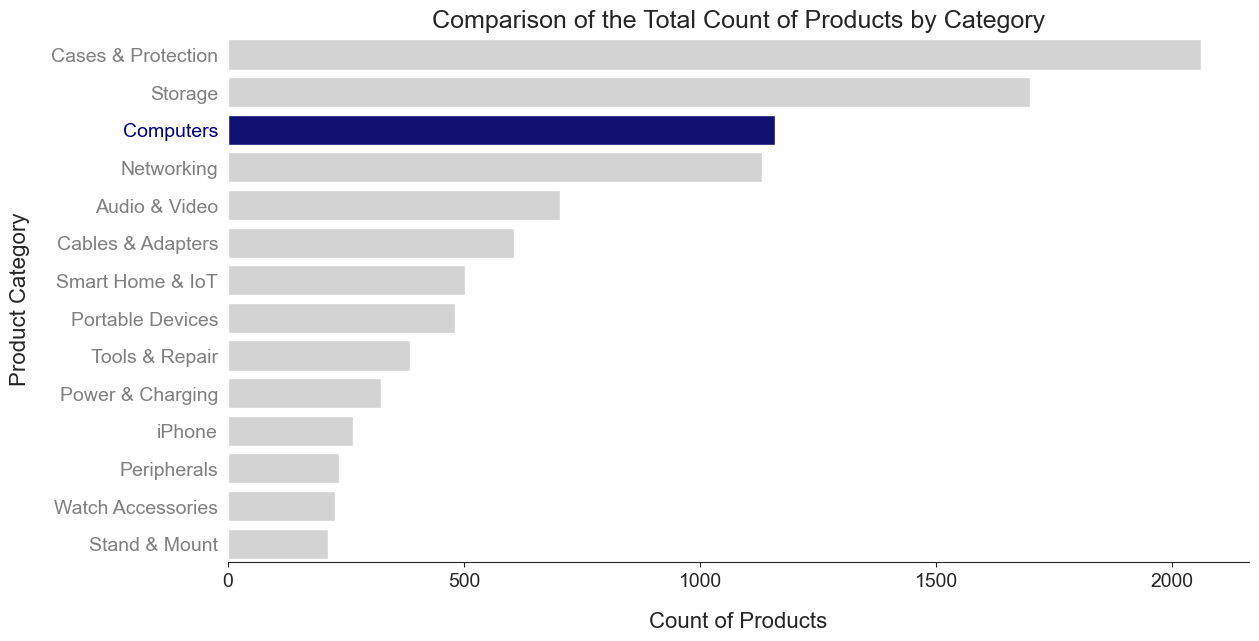

In [18]:
sns.set_style("white",                               # use a different predefined style.
              {'xtick.bottom': True,                 # override some of its defaults
              })                                     # Note: setting the style affects ALL plots from now on!


category_plot = sns.catplot(kind="count",
            data=products_qc_category_df,
            y="category",
            hue="category",
            palette=my_colors,
            order=ordered_category,
            height=6,
            aspect=2.0)

category_plot.ax.set_title('Comparison of the Total Count of Products by Category',
                      fontsize=18)
category_plot.set_axis_labels("Count of Products", "Product Category", fontsize=16,
                        labelpad=15);                    # move the labels slightly away from the ticks
category_plot.ax.set_xticks([0, 500, 1000, 1500, 2000])              # show different xticks

category_plot.ax.set_xticklabels(category_plot.ax.get_xticklabels(), fontsize=14) # change the xlabel sizes
category_plot.ax.set_yticks(category_plot.ax.get_yticks())                        # set the yticks explicitly before the next step
category_plot.ax.set_yticklabels(category_plot.ax.get_yticklabels(), fontsize=14) # change the ylabel sizes

# use list comprehension to change label colors:
[label.set_color('navy') if label.get_text() == "Computers" else label.set_color('gray') for label in category_plot.ax.get_yticklabels()]
category_plot.ax.spines['left'].set_visible(False)        # remove the edge to the left
#category_plot.ax.spines['bottom'].set_bounds(0,2500);      # let the bottom axis stop at the last tick

plt.show()



# Analyze Discounts

In [19]:
orderlines_qc_df = pd.read_csv('3_Data_Cleaning/data/orderlines_qc_df.csv')
orderlines_qc_df

,id,id_order,product_id,product_quantity,sku,unit_price,date,unit_price_total
0,1119116,299545,0,1,OWC0100,47.49,2017-01-01 01:46:16,47.49
1,1119119,299546,0,1,IOT0014,18.99,2017-01-01 01:50:34,18.99
2,1119120,295347,0,1,APP0700,72.19,2017-01-01 01:54:11,72.19
3,1119126,299549,0,1,PAC0929,2565.99,2017-01-01 02:07:42,2565.99
4,1119134,299556,0,1,CRU0039-A,60.90,2017-01-01 02:20:14,60.90
...,...,...,...,...,...,...,...,...
57969,1649447,527035,0,1,APP0698,9.99,2018-03-14 11:42:41,9.99
57970,1649512,527070,0,2,APP0698,9.99,2018-03-14 11:49:01,19.98
57971,1649522,527074,0,2,APP0698,9.99,2018-03-14 11:49:36,19.98
57972,1649565,527096,0,3,APP0698,9.99,2018-03-14 11:54:35,29.97


In [20]:
# Merge the orderlines_qc_df and products_qc_df
orderlines_product_merged_df = orderlines_qc_df.merge(products_qc_category_df, on='sku', how='left')

orderlines_product_merged_df

,id,id_order,product_id,product_quantity,sku,unit_price,date,unit_price_total,brand,name,desc,type,price,category,subcategory
0,1119116,299545,0,1,OWC0100,47.49,2017-01-01 01:46:16,47.49,OWC,OWC In-line Digital Temperature Sensor Kit HDD...,Kit temperature sensor for HDD iMac 21 inch an...,12755395,60.99,Tools & Repair,Replacement Part
1,1119119,299546,0,1,IOT0014,18.99,2017-01-01 01:50:34,18.99,iOttie,iOttie Easy View 2 Car Black Support,IPhone car holder 7 plus / 7/6 Plus / 6 / 5s /...,5720,22.95,Stand & Mount,Support
2,1119120,295347,0,1,APP0700,72.19,2017-01-01 01:54:11,72.19,Apple,Apple 85W MagSafe 2 charger MacBook Pro screen...,Apple MagSafe 2 Charger for MacBook Pro 15-inc...,13005399,89.00,Power & Charging,Charger
3,1119126,299549,0,1,PAC0929,2565.99,2017-01-01 02:07:42,2565.99,Pack,"Apple iMac 27 ""Core i5 3.2GHz Retina 5K | 32GB...",IMac desktop computer 27 inch Retina 5K RAM 32...,1282,3209.00,Computers,iMac
4,1119134,299556,0,1,CRU0039-A,60.90,2017-01-01 02:20:14,60.90,Crucial,(Open) Crucial 240GB SSD 7mm BX200,SSD hard drive and high-speed performance with...,1298,76.99,Storage,SSD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57969,1649447,527035,0,1,APP0698,9.99,2018-03-14 11:42:41,9.99,Apple,Apple Lightning Cable Connector to USB 1m Whit...,Apple Lightning USB Cable 1 meter to charge an...,1230,25.00,Cables & Adapters,Lightning USB Cable
57970,1649512,527070,0,2,APP0698,9.99,2018-03-14 11:49:01,19.98,Apple,Apple Lightning Cable Connector to USB 1m Whit...,Apple Lightning USB Cable 1 meter to charge an...,1230,25.00,Cables & Adapters,Lightning USB Cable
57971,1649522,527074,0,2,APP0698,9.99,2018-03-14 11:49:36,19.98,Apple,Apple Lightning Cable Connector to USB 1m Whit...,Apple Lightning USB Cable 1 meter to charge an...,1230,25.00,Cables & Adapters,Lightning USB Cable
57972,1649565,527096,0,3,APP0698,9.99,2018-03-14 11:54:35,29.97,Apple,Apple Lightning Cable Connector to USB 1m Whit...,Apple Lightning USB Cable 1 meter to charge an...,1230,25.00,Cables & Adapters,Lightning USB Cable


In [21]:
# Calculate the discount for each product
orderlines_product_merged_df['discount'] = orderlines_product_merged_df['price'] - orderlines_product_merged_df['unit_price']
orderlines_product_merged_df

,id,id_order,product_id,product_quantity,sku,unit_price,date,unit_price_total,brand,name,desc,type,price,category,subcategory,discount
0,1119116,299545,0,1,OWC0100,47.49,2017-01-01 01:46:16,47.49,OWC,OWC In-line Digital Temperature Sensor Kit HDD...,Kit temperature sensor for HDD iMac 21 inch an...,12755395,60.99,Tools & Repair,Replacement Part,13.50
1,1119119,299546,0,1,IOT0014,18.99,2017-01-01 01:50:34,18.99,iOttie,iOttie Easy View 2 Car Black Support,IPhone car holder 7 plus / 7/6 Plus / 6 / 5s /...,5720,22.95,Stand & Mount,Support,3.96
2,1119120,295347,0,1,APP0700,72.19,2017-01-01 01:54:11,72.19,Apple,Apple 85W MagSafe 2 charger MacBook Pro screen...,Apple MagSafe 2 Charger for MacBook Pro 15-inc...,13005399,89.00,Power & Charging,Charger,16.81
3,1119126,299549,0,1,PAC0929,2565.99,2017-01-01 02:07:42,2565.99,Pack,"Apple iMac 27 ""Core i5 3.2GHz Retina 5K | 32GB...",IMac desktop computer 27 inch Retina 5K RAM 32...,1282,3209.00,Computers,iMac,643.01
4,1119134,299556,0,1,CRU0039-A,60.90,2017-01-01 02:20:14,60.90,Crucial,(Open) Crucial 240GB SSD 7mm BX200,SSD hard drive and high-speed performance with...,1298,76.99,Storage,SSD,16.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57969,1649447,527035,0,1,APP0698,9.99,2018-03-14 11:42:41,9.99,Apple,Apple Lightning Cable Connector to USB 1m Whit...,Apple Lightning USB Cable 1 meter to charge an...,1230,25.00,Cables & Adapters,Lightning USB Cable,15.01
57970,1649512,527070,0,2,APP0698,9.99,2018-03-14 11:49:01,19.98,Apple,Apple Lightning Cable Connector to USB 1m Whit...,Apple Lightning USB Cable 1 meter to charge an...,1230,25.00,Cables & Adapters,Lightning USB Cable,15.01
57971,1649522,527074,0,2,APP0698,9.99,2018-03-14 11:49:36,19.98,Apple,Apple Lightning Cable Connector to USB 1m Whit...,Apple Lightning USB Cable 1 meter to charge an...,1230,25.00,Cables & Adapters,Lightning USB Cable,15.01
57972,1649565,527096,0,3,APP0698,9.99,2018-03-14 11:54:35,29.97,Apple,Apple Lightning Cable Connector to USB 1m Whit...,Apple Lightning USB Cable 1 meter to charge an...,1230,25.00,Cables & Adapters,Lightning USB Cable,15.01


In [22]:
orderlines_product_merged_df['discount_flag'] = (
    orderlines_product_merged_df['unit_price'] < 
    orderlines_product_merged_df['price']
)

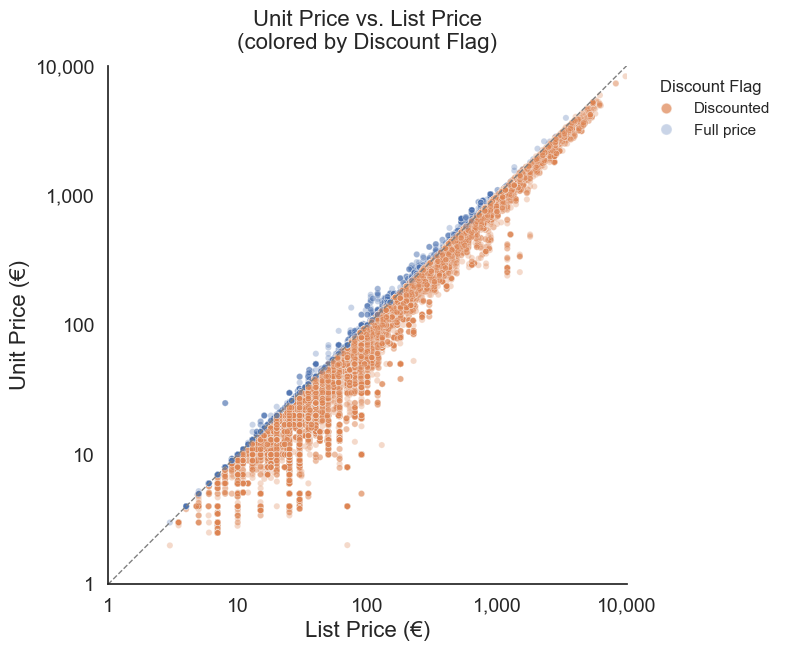

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.stats import linregress

# 0. Prep
df = orderlines_product_merged_df.copy()
df['discount_flag'] = df['unit_price'] < df['price']

# Compute Pearson r
slope, intercept, r_value, p_value, stderr = linregress(
    df['price'], df['unit_price']
)

# 1. Start plot
sns.set_style("white",                               
              #{'xtick.bottom': True,}
              )  
fig, ax = plt.subplots(figsize=(8, 8))

# 2. Scatter
sns.scatterplot(
    data=df,
    x="price",
    y="unit_price",
    hue="discount_flag",
    palette={False: "#4C72B0", True: "#DD8452"},
    alpha=0.3,
    s=20,
    ax=ax,
    legend=False   # we'll add a custom legend
)

# 3. Diagonal y=x line
min_val = min(ax.get_xlim()[0], ax.get_ylim()[0])
max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot(
    [min_val, max_val],
    [min_val, max_val],
    ls="--", lw=1, color="gray"
)

# 4. Log–Log scaling & equal aspect
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_aspect('equal', 'box')

# 5. Format ticks with thousands separator
fmt = mticker.FuncFormatter(lambda x, _: f"{x:,.0f}")
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)

ax.set_xlim(1, 10000)
ax.set_ylim(1, 10000)
ax.tick_params(axis='both', which='major', labelsize=14)

# 6. Annotate Pearson r
# ax.text(
#     0.05, 0.95,
#     f"Pearson r = {r_value:.2f}",
#     transform=ax.transAxes,
#     ha="left", va="top",
#     bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.5)
# )

# 7. Title & labels
ax.set_title("Unit Price vs. List Price\n(colored by Discount Flag)", fontsize=16, pad=12)
ax.set_xlabel("List Price (€)", fontsize=16)
ax.set_ylabel("Unit Price (€)", fontsize=16)

# 8. Custom legend outside
# create proxy artists
from matplotlib.lines import Line2D
proxies = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor="#DD8452", markersize=8, alpha=0.7),
    Line2D([0], [0], marker='o', color='w', markerfacecolor="#4C72B0", markersize=8, alpha=0.3)
]
ax.legend(
    proxies, ["Discounted","Full price"],
    title="Discount Flag",
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    frameon=False
)

# 9. Remove top/right spines
sns.despine(trim=False)

plt.tight_layout()
plt.show()
